# Problema

Predecir el coste del seguro

## Instrucciones

 Utilizar el dataset (insurance.csv) para entrenar un modelo de regresión capaz de predecir el valor del seguro en función de las características del cliente. Realizar limpieza, preprocesado modelado y testeo del modelo aportando conclusiones de todos estos pasos.

# El set de datos

* age: age of primary beneficiary

* sex: insurance contractor gender, female, male

* bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

* children: Number of children covered by health insurance / Number of dependents

* smoker: Smoking

* region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

* charges: Individual medical costs billed by health insurance



In [65]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [66]:
ruta = "insurance.csv"
data = pd.read_csv(ruta)

In [67]:
print(data.shape)
data.head()

(1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Objetivo

Generar un model de regresión capaz de predecir el valor del seguro en base a las características del cliente.

* Aplicar las técnicas oportunas de procesamiento de datos (lipieza, nans, escalado...)

* Valorar diferentes modelos de regresión (linear regressor, polynomial, ridge, lasso, elastic, decission tree y random forest)

* Comparación entre modelos (dividir el dataset en train y test, entrenar con el train y evaluar con el test)

* Métricas (todas, y que aporta cada una)

* Conclusiones finales

## Implementación

Primero de todo veamos la cantidad de datos faltantes que hay en el dataset

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [69]:
numerical_cols = ["age", "bmi", "children", "charges"]

data.isnull().sum(), data.count()

(age         0
 sex         0
 bmi         0
 children    0
 smoker      0
 region      0
 charges     0
 dtype: int64,
 age         1338
 sex         1338
 bmi         1338
 children    1338
 smoker      1338
 region      1338
 charges     1338
 dtype: int64)

En cuanto a los numericos no hay datos faltantes. Veamos los categoricos:

In [70]:
categorical_columns = ["sex", "smoker", "region"]

for col in categorical_columns:
    print(set(data[col]))

{'male', 'female'}
{'yes', 'no'}
{'northwest', 'northeast', 'southeast', 'southwest'}


Ahora hagamos un analisis de los datos, para poder ver la distribucion, las correlaciones...

### AGE

{'whiskers': [<matplotlib.lines.Line2D at 0x18cb1d8b1d0>,
 'caps': [<matplotlib.lines.Line2D at 0x18cb1d8b740>,
 'boxes': [<matplotlib.lines.Line2D at 0x18cb1d8b020>],
 'medians': [<matplotlib.lines.Line2D at 0x18cb1d89c40>],
 'fliers': [<matplotlib.lines.Line2D at 0x18cb1d89ee0>],
 'means': []}

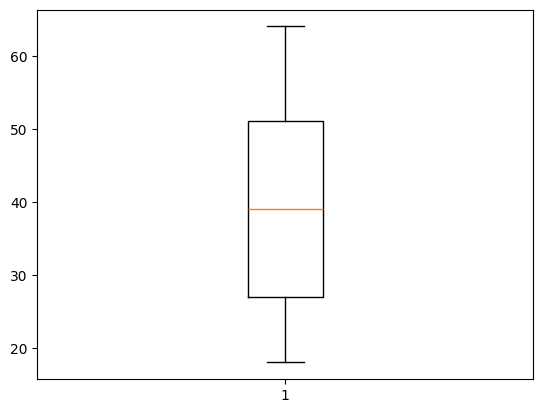

In [71]:
plt.boxplot(data["age"])

### SEX

<Axes: xlabel='count', ylabel='sex'>

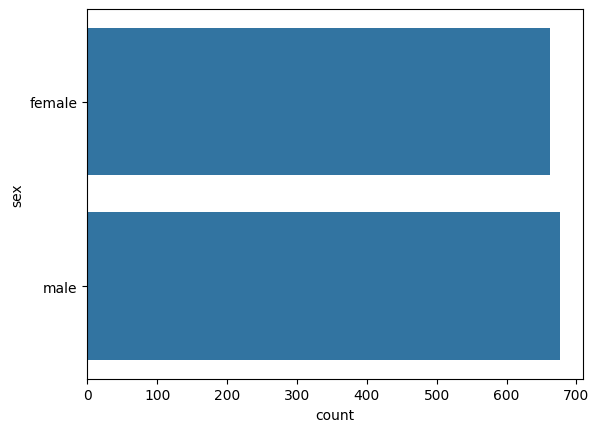

In [72]:
sns.countplot(data["sex"])

No estan desbalanceadas las clases, lo cual es muy positivo para el modelo.

### BMI

<Axes: ylabel='bmi'>

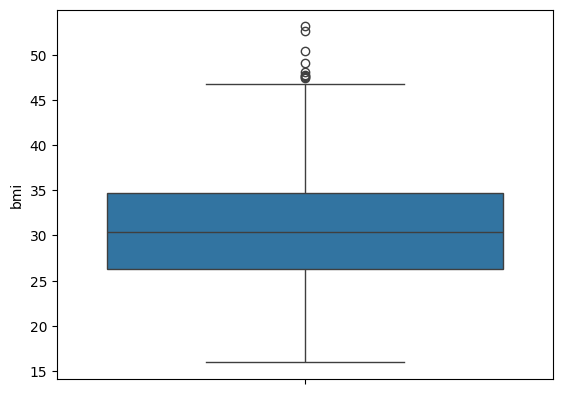

In [73]:
sns.boxplot(data["bmi"])

Vemos que hay algunos outliers, vamos a ver cuantos hay y que hacemos con ello.

In [74]:
# Calcular Q1, Q3 y IQR
Q1 = data['bmi'].quantile(0.25)
Q3 = data['bmi'].quantile(0.75)
IQR = Q3 - Q1

# Límite inferior y superior
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar outliers
outliers = data[(data['bmi'] < lower_bound) | (data['bmi'] > upper_bound)]

# Mostrar resultados
print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
print(f"Límite inferior: {lower_bound}, Límite superior: {upper_bound}")
print(f"Número de outliers: {len(outliers)}")
print("Outliers encontrados:")
print(outliers)


Q1: 26.29625, Q3: 34.69375, IQR: 8.3975
Límite inferior: 13.7, Límite superior: 47.290000000000006
Número de outliers: 9
Outliers encontrados:
      age     sex    bmi  children smoker     region      charges
116    58    male  49.06         0     no  southeast  11381.32540
286    46  female  48.07         2     no  northeast   9432.92530
401    47    male  47.52         1     no  southeast   8083.91980
543    54  female  47.41         0    yes  southeast  63770.42801
847    23    male  50.38         1     no  southeast   2438.05520
860    37  female  47.60         2    yes  southwest  46113.51100
1047   22    male  52.58         1    yes  southeast  44501.39820
1088   52    male  47.74         1     no  southeast   9748.91060
1317   18    male  53.13         0     no  southeast   1163.46270


Como hay solo 9 outliers de los más de 1300 datos que tenmos y no se van mucho, es decir, que no son errores, vamos a clipearlos. Otra opción sería eliminarlos.

In [75]:
# Clipear los datos
data['bmi'] = data['bmi'].clip(lower=lower_bound, upper=upper_bound)

outliers = data[(data['bmi'] < lower_bound) | (data['bmi'] > upper_bound)]

# Mostrar resultados
print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
print(f"Límite inferior: {lower_bound}, Límite superior: {upper_bound}")
print(f"Número de outliers: {len(outliers)}")
print("Outliers encontrados:")
print(outliers)

Q1: 26.29625, Q3: 34.69375, IQR: 8.3975
Límite inferior: 13.7, Límite superior: 47.290000000000006
Número de outliers: 0
Outliers encontrados:
Empty DataFrame
Columns: [age, sex, bmi, children, smoker, region, charges]
Index: []


### CHILDREN

<Axes: ylabel='children'>

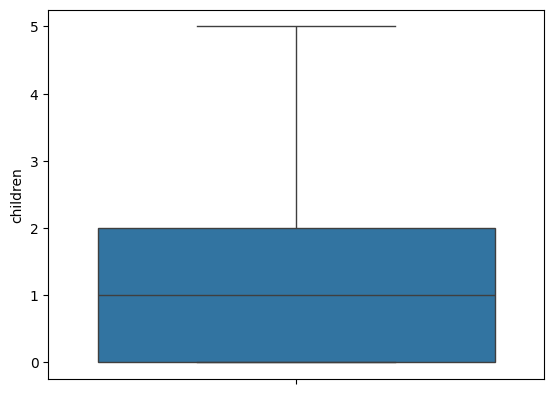

In [76]:
sns.boxplot(data["children"])

### SMOKER

<Axes: xlabel='count', ylabel='smoker'>

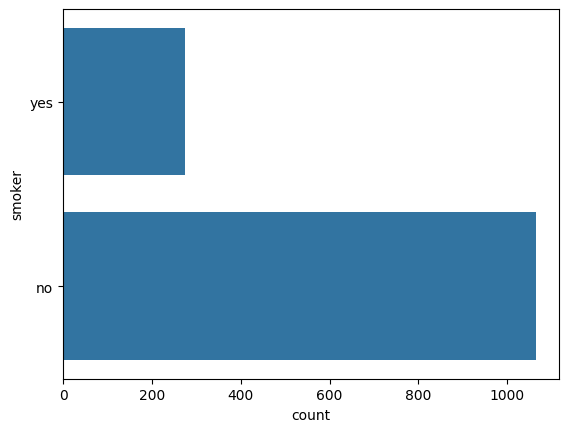

In [77]:
sns.countplot(data["smoker"])

Esta bastante desbalanceada y es normal, ya que habrá más gente no fumadora que sí. De momento no realizaremos nada de balanceo pero podriamos balanceando ya sea, quitando datos de los no fumadores o añadiendo datos inventados de los de si.

### REGION

<Axes: xlabel='count', ylabel='region'>

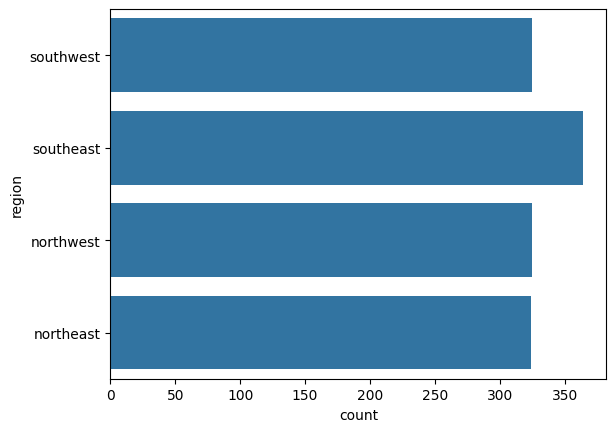

In [78]:
sns.countplot(data["region"])

La región tambien esta muy balanceado.

Ahora veamos las correlaciones que hay respecto al target. Para ello vamos a convertir las categoricas.

In [79]:
from sklearn.preprocessing import LabelEncoder

# Convertir con LabelEncoder
encoder = LabelEncoder()

for col in categorical_columns:
    data[col] = encoder.fit_transform(data[col])

print(data.head())


   age  sex     bmi  children  smoker  region      charges
0   19    0  27.900         0       1       3  16884.92400
1   18    1  33.770         1       0       2   1725.55230
2   28    1  33.000         3       0       2   4449.46200
3   33    1  22.705         0       0       1  21984.47061
4   32    1  28.880         0       0       1   3866.85520


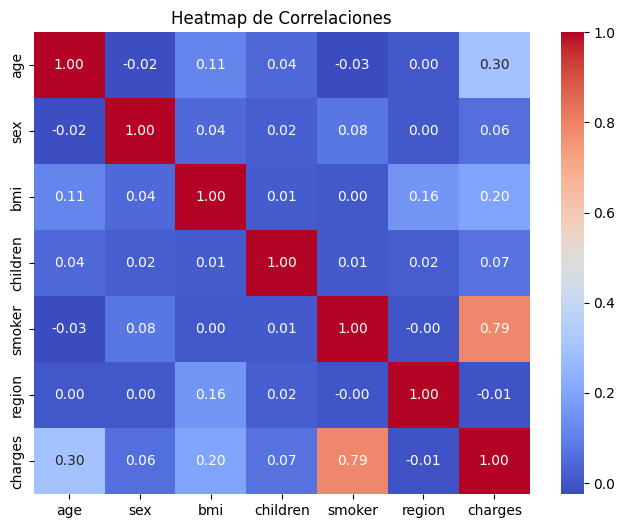

In [80]:
correlation_matrix = data.corr()

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Heatmap de Correlaciones')
plt.show()

Tiene sentido que las dos que más correlacion tengan sean las columnas "smoker", "age" y "bmi". Y las que menos las columnas "region", "sex" y "children".

Como la region considero que es algo que no es relevante y además la grafica me refuerza esta idea, prodecemos a eliminarla para quitarle ruido al modelo. En un futuro podemos añadirla para ver como afectaria.

In [81]:
data = data.drop("region", axis=1)

data.head()

,age,sex,bmi,children,smoker,charges
0,19,0,27.900,0,1,16884.92400
1,18,1,33.770,1,0,1725.55230
2,28,1,33.000,3,0,4449.46200
3,33,1,22.705,0,0,21984.47061
4,32,1,28.880,0,0,3866.85520


Ya acabado el analis exploratorio de los datos vamos a realizar el escalado

In [82]:
from sklearn.preprocessing import MinMaxScaler

X = data.drop("charges", axis=1)
y = data["charges"]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:2]

array([[0.02173913, 0.        , 0.38110437, 0.        , 1.        ],
       [0.        , 1.        , 0.56846473, 0.2       , 0.        ]])

Ya realizado todo el preprocesado, vamos a pasar con la particion de los datos.

In [84]:
from sklearn.model_selection import train_test_split

# Primero, dividimos en train y test
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Luego, dividimos el conjunto temporal en validación y prueba (50% de 0.3 es 0.15, por lo que 0.15 es el tamaño del conjunto de validación)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Y por ultimo vamos a probar los modelos de regresión de gridsearch para ver cual es el modelo con mejor resultado.

In [88]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline

models = {
    'LinearRegression': LinearRegression(),
    'PolynomialRegression': Pipeline([('poly', PolynomialFeatures()), ('linreg', LinearRegression())]),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor()
}

param_grid = {
    'LinearRegression': {},
    'PolynomialRegression': {
        'poly__degree': [2, 3, 4]  # Probar diferentes grados de polinomios
    },
    'Ridge': {
        'alpha': [0.1, 1, 10, 100]  # Parámetros de regularización
    },
    'Lasso': {
        'alpha': [0.1, 1, 10, 100]  # Parámetros de regularización
    },
    'ElasticNet': {
        'alpha': [0.1, 1, 10, 100],  # Parámetros de regularización
        'l1_ratio': [0.2, 0.5, 0.8, 1.0]  # Combinación entre L1 y L2
    },
    'DecisionTree': {
        'max_depth': [5, 10, 15],  # Profundidad máxima
        'min_samples_split': [2, 5, 10]  # Número mínimo de muestras para dividir un nodo
    },
    'RandomForest': {
        'n_estimators': [100, 200],  # Número de árboles
        'max_depth': [5, 10, 15],  # Profundidad máxima de los árboles
        'min_samples_split': [2, 5, 10]  # Número mínimo de muestras para dividir un nodo
    }
}

best_models = {}
for name, model in models.items():
    print(f"Realizando GridSearchCV para {name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid[name], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Mejor {name} modelo: {grid_search.best_estimator_}")
    print(f"Mejores hiperparámetros: {grid_search.best_params_}\n")

results = {}
for name, model in best_models.items():
    y_pred = model.predict(X_val)
    
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    results[name] = {'MSE': mse, 'MAE': mae, 'R²': r2}
    print(f"Evaluación para {name}:")
    print(f"  MSE: {mse}")
    print(f"  MAE: {mae}")
    print(f"  R²: {r2}\n")

results_df = pd.DataFrame(results).T
print("Comparación entre modelos:")
print(results_df)

Realizando GridSearchCV para LinearRegression...
Mejor LinearRegression modelo: LinearRegression()
Mejores hiperparámetros: {}

Realizando GridSearchCV para PolynomialRegression...
Mejor PolynomialRegression modelo: Pipeline(steps=[('poly', PolynomialFeatures()), ('linreg', LinearRegression())])
Mejores hiperparámetros: {'poly__degree': 2}

Realizando GridSearchCV para Ridge...
Mejor Ridge modelo: Ridge(alpha=0.1)
Mejores hiperparámetros: {'alpha': 0.1}

Realizando GridSearchCV para Lasso...
Mejor Lasso modelo: Lasso(alpha=10)
Mejores hiperparámetros: {'alpha': 10}

Realizando GridSearchCV para ElasticNet...
Mejor ElasticNet modelo: ElasticNet(alpha=10, l1_ratio=1.0)
Mejores hiperparámetros: {'alpha': 10, 'l1_ratio': 1.0}

Realizando GridSearchCV para DecisionTree...
Mejor DecisionTree modelo: DecisionTreeRegressor(max_depth=5, min_samples_split=10)
Mejores hiperparámetros: {'max_depth': 5, 'min_samples_split': 10}

Realizando GridSearchCV para RandomForest...
Mejor RandomForest modelo

Despues de obtener el dataframe con los resultados de cada modelo nos quedamos con el RandomForest ya que nos da un mae menor. Consideramos esta metrica como la mejor ya que al ser valores muy altos, el mae te dice cuanto se puede desviar el dato por arriba y por abajo.

Ahora vamos a ejecutar el mejor modelo con el test.

In [90]:
model = RandomForestRegressor(max_depth=5, min_samples_split=10, n_estimators=200)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Evaluación del test:")
print(f"  MSE: {mse}")
print(f"  MAE: {mae}")
print(f"  R²: {r2}\n")

Evaluación del test:
  MSE: 20939701.632451523
  MAE: 2615.9772384615385
  R²: 0.8619201103413066



# Conclusiones

Podemos decir que el modelo no da muy buenos resultados ya que se puede ir más de 2500 euros la prediccion y podria incluso dar datos negativos en algunos casos (no tiene sentido) o irse mucho porcentaje del valor.